This notebook tests behaviours of LongitudinalLiNGAM when n_lags is greater than 1.

## Library and Functions

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, Markdown

import lingam
print("lingam=", lingam.__version__)

np.random.seed(0)

def _make_dag(n_features=8):
    sign = np.random.choice([-1, 1], size=(n_features, n_features))
    coef = np.random.uniform(0.1, 0.9, size=(n_features, n_features))
    sparse = np.random.choice([0, 1], p=[0.3, 0.7], size=(n_features, n_features))

    graph = np.tril(sign * coef * sparse, k=-1)
    graph[np.isclose(graph, 0)] = 0
    
    G = nx.from_numpy_array(graph.T, create_using=nx.DiGraph)
    causal_order = list(nx.topological_sort(G))
    
    return graph, causal_order

def _make_tau_coefs(tau_len, n_features=8):
    coefs = []
    for i in range(tau_len):
        sign = np.random.choice([-1, 1], size=(n_features, n_features))
        coef = np.random.uniform(0.1, 0.9, size=(n_features, n_features))
        sparse = np.random.choice([0, 1], p=[0.5, 0.5], size=(n_features, n_features))

        coef = sign * coef * sparse
        coef[np.isclose(coef, 0)] = 0
        
        coefs.append(coef)
    return coefs

def make_data_set(obs_duration=10, n_lags=1, n_samples=1000, n_features=8):
    es = []
    causal_orders = []
    B = []
    X = []

    # initial data
    for tau in range(n_lags):
        X.append(np.zeros((n_features, n_samples)))

    # generate twice the data and use the second half of the data
    for t in range(len(X), obs_duration * 2):
        B_t, causal_order = _make_dag(n_features=n_features)
        B_taus = _make_tau_coefs(n_lags, n_features)

        e = np.random.uniform(0.1, 1.0, size=(n_features, n_samples))

        mix_mat = np.linalg.pinv(np.eye(n_features) - B_t)
        N_t = mix_mat @ e
        M_t = mix_mat @ np.hstack(B_taus)
        X_t = M_t @ np.vstack(X[t - n_lags:]) + N_t

        es.append(e.T)
        causal_orders.append(causal_order)
        B.append([B_t, *B_taus])
        X.append(X_t)

    B = np.array(B)[-obs_duration:]
    X = np.array(X)[-obs_duration:]
    X = np.transpose(X, [0, 2, 1])
    
    return X, B, causal_orders, es

def show_scatter(B_est, B_true):
    n_rows, n_cols = B_true.shape[:2]
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
    for t, (true, est) in enumerate(zip(B_true, B_est)):
        for tau, (t_, e_) in enumerate(zip(true, est)):
            axes[t, tau].scatter(t_, e_)
            if t == 0:
                axes[t, tau].set_title(f"tau={tau}")
        axes[t, 0].set_ylabel(f"t={t}")
    plt.tight_layout()
    plt.show()

lingam= 1.9.1


## Test

The horizontal axis of each scatter plot is the true value and the vertical axis is the estimated value.

### n_lags=1

[[nan, nan, nan, nan, nan, nan, nan, nan], [0, 1, 2, 4, 3, 5, 6, 7], [1, 0, 2, 3, 4, 5, 7, 6], [2, 0, 1, 3, 4, 5, 6, 7], [0, 1, 2, 4, 3, 5, 6, 7], [0, 5, 1, 2, 3, 4, 7, 6], [1, 0, 2, 3, 4, 5, 6, 7], [0, 3, 2, 1, 4, 5, 6, 7], [0, 1, 3, 2, 5, 4, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7]]


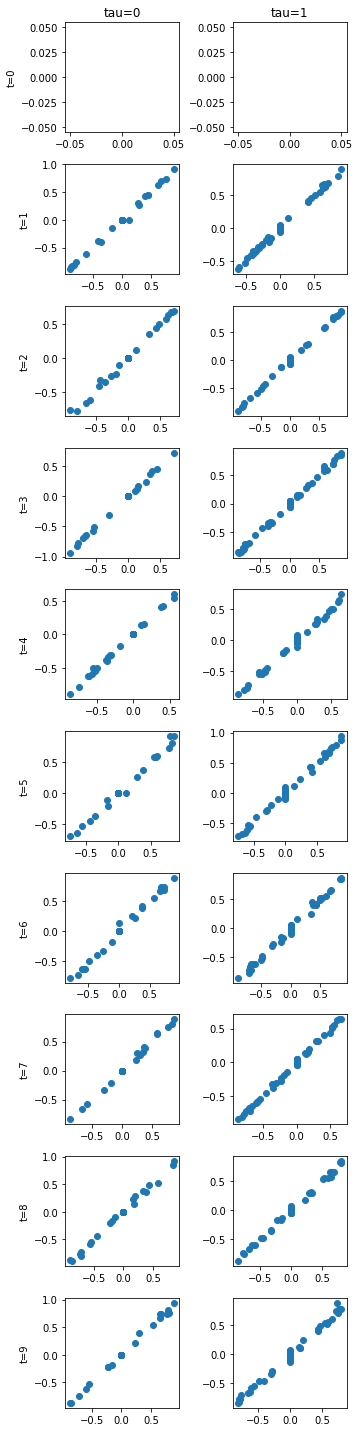

### n_lags=2

[[nan, nan, nan, nan, nan, nan, nan, nan], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 4, 3, 6, 5, 7], [1, 0, 2, 3, 4, 5, 6, 7], [1, 0, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 6, 5, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 4, 2, 3, 5, 6, 7], [0, 2, 1, 3, 4, 5, 6, 7]]


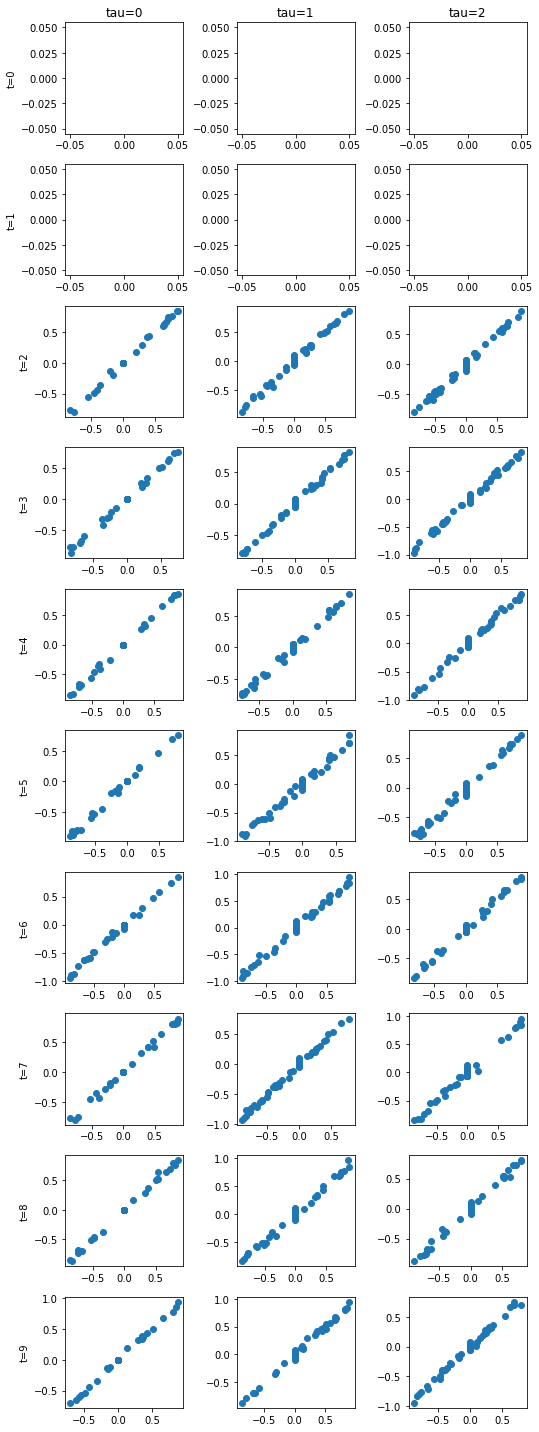

### n_lags=3

[[nan, nan, nan, nan, nan, nan, nan, nan], [0, 1, 2, 3, 4, 5, 7, 6], [0, 1, 2, 5, 7, 4, 3, 6], [0, 1, 2, 3, 4, 7, 5, 6], [0, 1, 2, 3, 4, 7, 5, 6], [1, 2, 3, 4, 5, 6, 7, 0], [1, 3, 0, 2, 4, 5, 6, 7], [0, 1, 2, 3, 6, 4, 5, 7]]


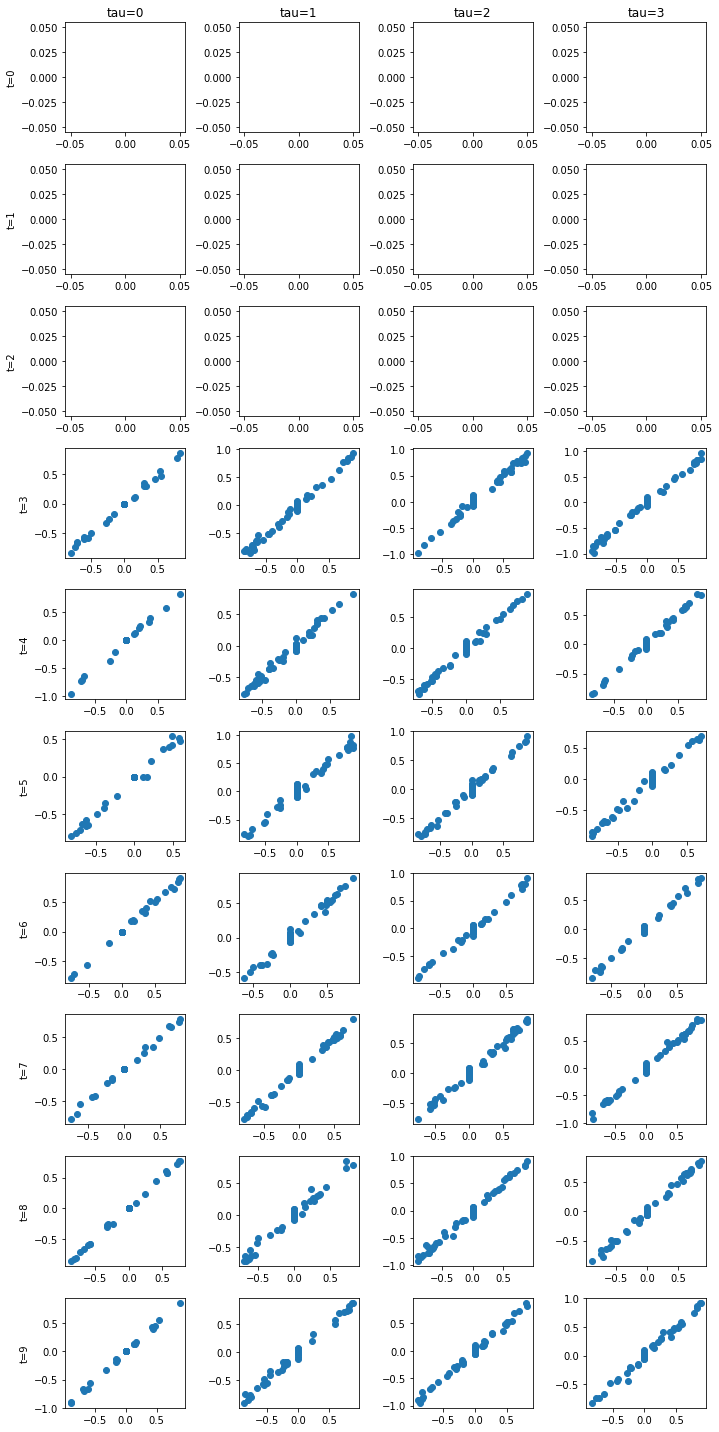

In [2]:
for n_lags in range(1, 4):
    display(Markdown(f"### n_lags={n_lags}"))

    X, B, causal_orders, es = make_data_set(n_lags=n_lags, obs_duration=10, n_features=8)

    model = lingam.LongitudinalLiNGAM(n_lags=n_lags)
    model.fit(X)

    print(model.causal_orders_)
    show_scatter(model.adjacency_matrices_, B)